In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import tensorflow as tf

import os
import time

Load Data

In [15]:
batches = []
for batch in os.listdir("data/batches"):
    if batch[0:5] == "batch":
        batches.append(np.fromfile("data/batches/" + batch, dtype=np.uint8, count=-1))
inputs = np.concatenate(batches)

labels = np.fromfile("data/batches/labels.bin", dtype=np.uint8, count=-1)

inputs = inputs.reshape((-1,128,128,3))
print(inputs.shape)

print(labels.shape)

(8424, 128, 128, 3)
(8424,)


In [3]:
print("number of recyclable items:", len(labels[labels[0]==0]))
print("number of maybe recyclable items:", len(labels[labels[0]==1]))

number of recyclable items: 0
number of maybe recyclable items: 1


In [4]:
enc = preprocessing.OneHotEncoder(categories="auto")
one_hot_labels = enc.fit_transform(labels.reshape((-1,1)))
test_size = 0.15
val_size = 0.1

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(inputs, labels,
                                                                              test_size = test_size, random_state = 0)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val,
                                                                        test_size = val_size / (1 - test_size), 
                                                                        random_state = 0)

print("X train:", X_train.shape)
print("Y train:", y_train.shape)
print("X validation:", X_val.shape)
print("Y validation:", y_val.shape)
print("X test:", X_test.shape)
print("Y test:", y_test.shape)

X train: (6317, 128, 128, 3)
Y train: (6317,)
X validation: (843, 128, 128, 3)
Y validation: (843,)
X test: (1264, 128, 128, 3)
Y test: (1264,)


recyclable


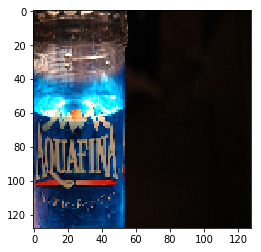

In [5]:
num = 1530
plt.imshow(inputs[num])
if labels[num] == 0:
    print("recyclable")
elif labels[num] == 1:
    print("non-recyclable")
else:
    print("label not 0 or 1")

In [6]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=[2,2]))


model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=[2,2]))

model.add(tf.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1000, activation=tf.nn.leaky_relu))

model.add(tf.keras.layers.Dense(units=2, activation=tf.nn.softmax))

model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.000001),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])

In [8]:
start = time.time()
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))
end = time.time()
print(end-start, "seconds elapsed")

Train on 6317 samples, validate on 843 samples
Epoch 1/10
6317/6317 [==============================] - 16s 3ms/step - loss: 2.8371 - acc: 0.5807 - val_loss: 3.0800 - val_acc: 0.5492
Epoch 2/10
6317/6317 [==============================] - 16s 3ms/step - loss: 2.6236 - acc: 0.5946 - val_loss: 3.0343 - val_acc: 0.5504
Epoch 3/10
6317/6317 [==============================] - 17s 3ms/step - loss: 2.4190 - acc: 0.6125 - val_loss: 2.9175 - val_acc: 0.5635
Epoch 4/10
6317/6317 [==============================] - 18s 3ms/step - loss: 2.3105 - acc: 0.6115 - val_loss: 2.8852 - val_acc: 0.5718
Epoch 5/10
6317/6317 [==============================] - 18s 3ms/step - loss: 2.1910 - acc: 0.6274 - val_loss: 2.8277 - val_acc: 0.5611
Epoch 6/10
6317/6317 [==============================] - 17s 3ms/step - loss: 2.1875 - acc: 0.6237 - val_loss: 2.8065 - val_acc: 0.5741
Epoch 7/10
6317/6317 [==============================] - 18s 3ms/step - loss: 2.0326 - acc: 0.6410 - val_loss: 2.7474 - val_acc: 0.5611
Epoch 8/

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
__________

In [10]:
p_train = model.predict(X_train)
p_train = np.argmax(p_train, axis=1)

p_val = model.predict(X_val)
p_val = np.argmax(p_val, axis=1)

print("train acc:", metrics.accuracy_score(y_train, p_train))
print("validation acc:", metrics.accuracy_score(y_val, p_val))

train acc: 0.6181731834731676
validation acc: 0.5670225385527876


In [11]:
p_test = model.predict(X_test)
p_test = np.argmax(p_test, axis=1)

print("test acc:", metrics.accuracy_score(y_test, p_test))

test acc: 0.5680379746835443


In [12]:
p_test = model.predict(inputs)
p_test = np.argmax(p_test, axis=1)

print("test acc:", metrics.accuracy_score(labels, p_test))

test acc: 0.6055318138651472
